<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Conditional_Generative_Adversarial_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conditional Generative Adversarial Nets**

논문 링크: https://arxiv.org/abs/1411.1784

CGAN은 2014년도에 나온 모델로써, DCGAN보다 먼저 나왔다. CGAN의 경우 GAN과 학습 방법 자체는 별로 다를 것이 없다.

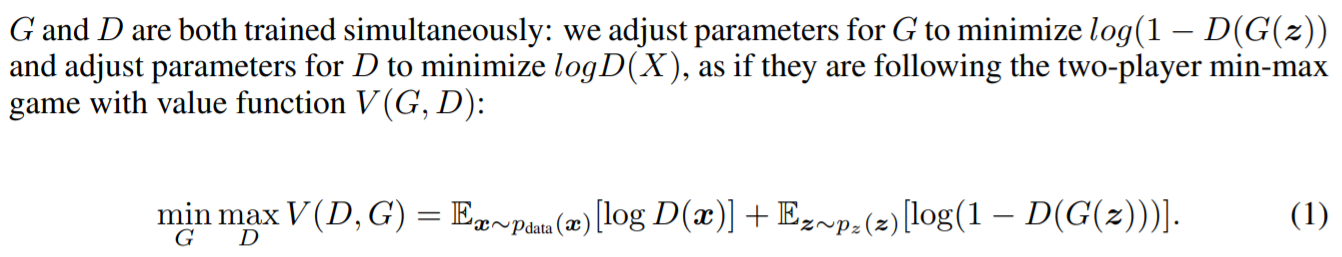

위의 식은 많이 봐서 바로 알겠지만, original GAN의 loss function이다.

## **CGAN 구조**

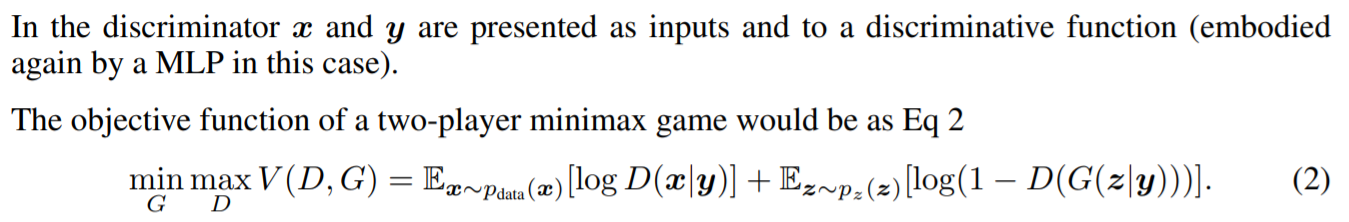

기존 GAN에서 G와 D에 추가 정보 y라는 조건이 붙는다면 조건부 생성모델을 만들 수 있다. y의 경우, 어떤 보조 정보도 가능하다.(class label 등등) 이렇게 y를 G와 D의 input layer에 추가로 같이 넘으로써 위와 같은 식이 된다.

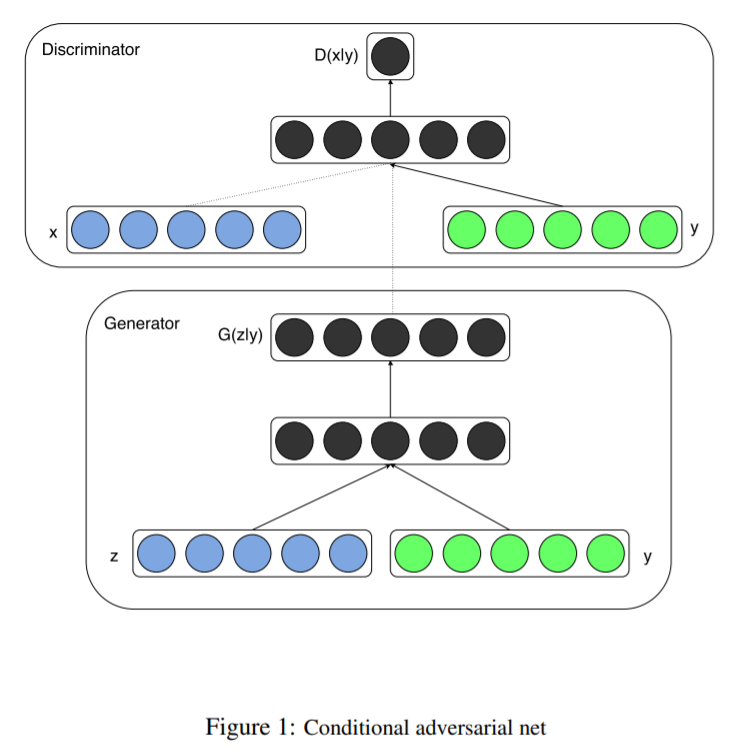

위의 그림 Figure 1은 위에서 설명한 것을 그림으로 나타낸 것이다.

자세한 모델 구조는

**Generator**
- uniform distribution z size = 100
- z와 y의 size = 200, 1000 짜리 hidden layer(ReLU)로 매핑됨
- 1200짜리 hidden layer로 합쳐짐(ReLU)
- 마지막으로 784 차원으로 변경(MNIST)

**Discriminator**
- x는 240 unit과 5 piece짜리 maxout layer로 매핑
- y는 50 unit과 5 piece 짜리 maxout layer로 매핑
- 240 unit, 5 piece 짜리 maxout layer로 합쳐진 후 Sigmoid

### **Pytorch**

In [1]:
import torch
import torch.nn as nn

# CGAN Generator
# in_features = latent_dim + num_class
# out_features = int(np.prod(channels, img_size, img_size))
class Generator(nn.Module):
    def __init__(self,  latent_dim=100, num_class=10, nker=128, norm='bnorm'):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_class, num_class)

        # Linear vector (100,)과 matrix (100, 1, 1)의 정보량은 동일
        self.dec1 = LDBR2d(latent_dim + num_class, nker, dropout=False, norm=norm, relu=0.2)
        self.dec2 = LDBR2d(nker, 2 * nker, dropout=False, norm=norm, relu=0.2)
        self.dec3 = LDBR2d(2 * nker, 4 * nker, dropout=False, norm=norm, relu=0.2)
        self.dec4 = LDBR2d(4 * nker, 8 * nker, dropout=False, norm=norm, relu=0.2)
        self.dec5 = LDBR2d(8 * nker, (1 * 32 * 32), dropout=False, norm=None, relu=None)
        self.tanh = nn.Tanh()

    # y = label
    def forward(self, z, y):
        x = torch.cat((self.label_emb(y), z), -1)

        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.dec5(x)
        x = self.tanh(x)

        x = x.view(x.size(0), *(1, 32, 32))
        return x


# CGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self,  latent_dim=100, num_class=10, nker=128, norm='bnorm'):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(num_class, num_class)

        self.enc1 = LDBR2d(num_class + (1 * 32 * 32), 4 * nker, dropout=False, norm=None, relu=0.2)
        self.enc2 = LDBR2d(4 * nker, 4 * nker, dropout=True, norm=None, relu=0.2)
        self.enc3 = LDBR2d(4 * nker, 4 * nker, dropout=True, norm=None, relu=0.2)
        self.env4 = LDBR2d(4 * nker, 1, dropout=False, norm=None, relu=None)
        # self.sig = nn.Sigmoid()

    # y = label
    def forward(self, x, y):
        x = torch.cat((x.view(x.size(0), -1), self.label_emb(y)), -1)

        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        
        # x = self.sig(x)

        return x


class LDBR2d(nn.Module):
    def __init__(self, in_features, out_features, dropout=False, norm='bnorm', relu=0.0):
        super().__init__()

        layers = []
        layers += [nn.Linear(in_features=in_features, out_features=out_features)]

        if dropout == True:
            layers += [nn.Dropout(0.4)]

        if not norm is None:
            if norm == 'bnorm':
                layers += [nn.BatchNorm1d(num_features=out_features)]
            elif norm == 'inorm':
                layers += [nn.InstanceNorm1d(num_features=out_features)]

        if relu >= 0.0:
            layers += [nn.ReLU() if relu == 0 else nn.LeakyReLU(relu)]

        self.ldbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.ldbr(x)

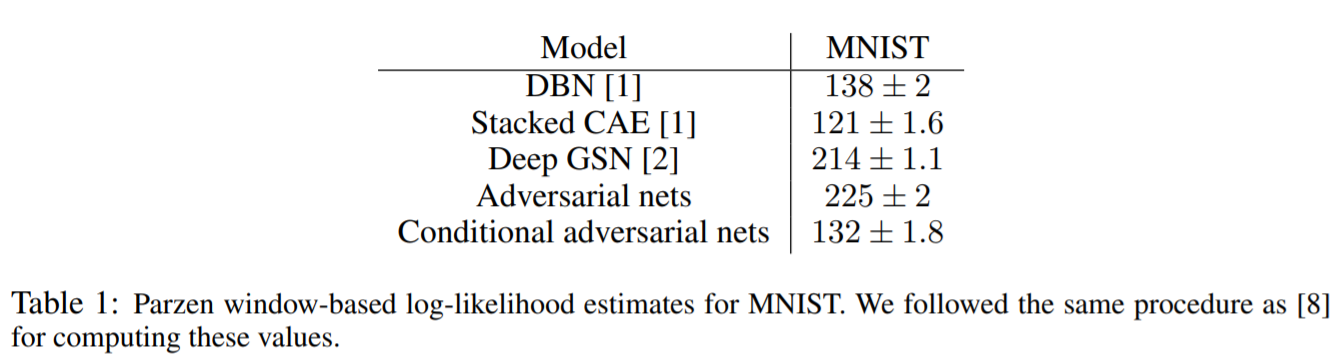

위의 테이블 Table 1은 MNIST로 실험한 결과다. Log-likelihood 값이 잘 나온 것을 확인할 수 있다.

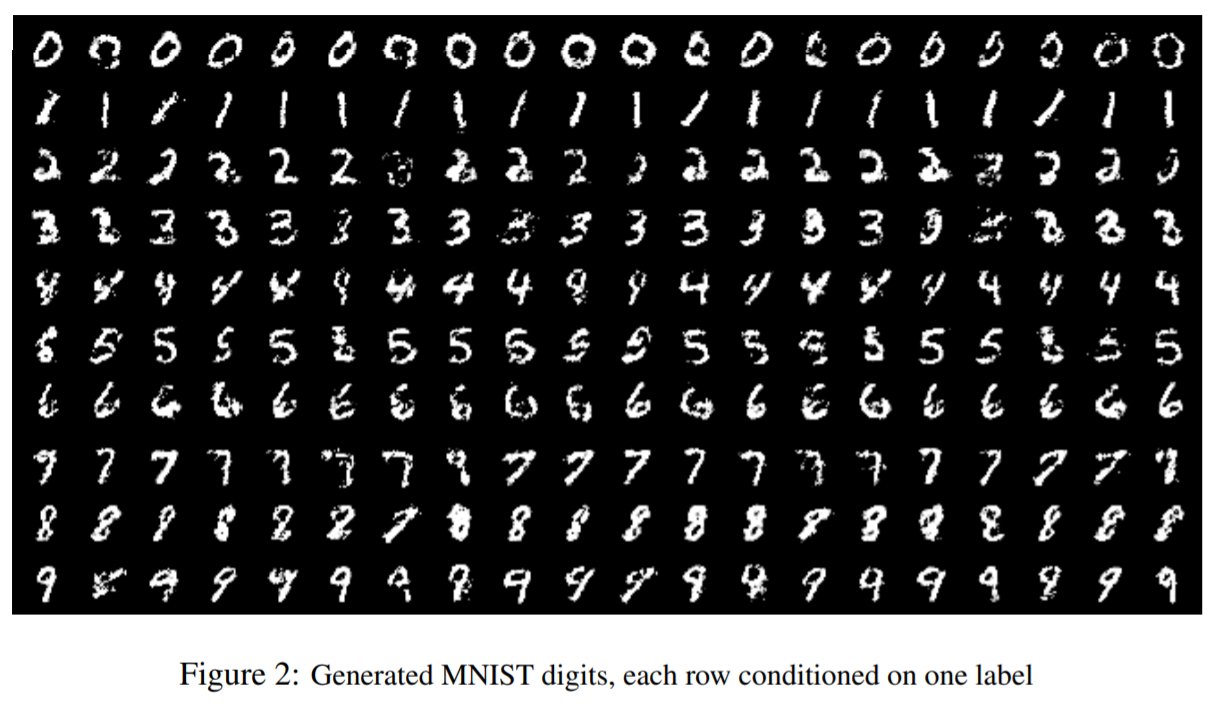

위의 그림 Figure 2는 y 데이터에 각 row 별로 0~9까지 넣어 생성된 이미지다. 주어진 조건(y)에 따라 class가 잘 나뉘는 것을 확인할 수 있다. (이미지의 품질은 original GAN과 비슷하다.)

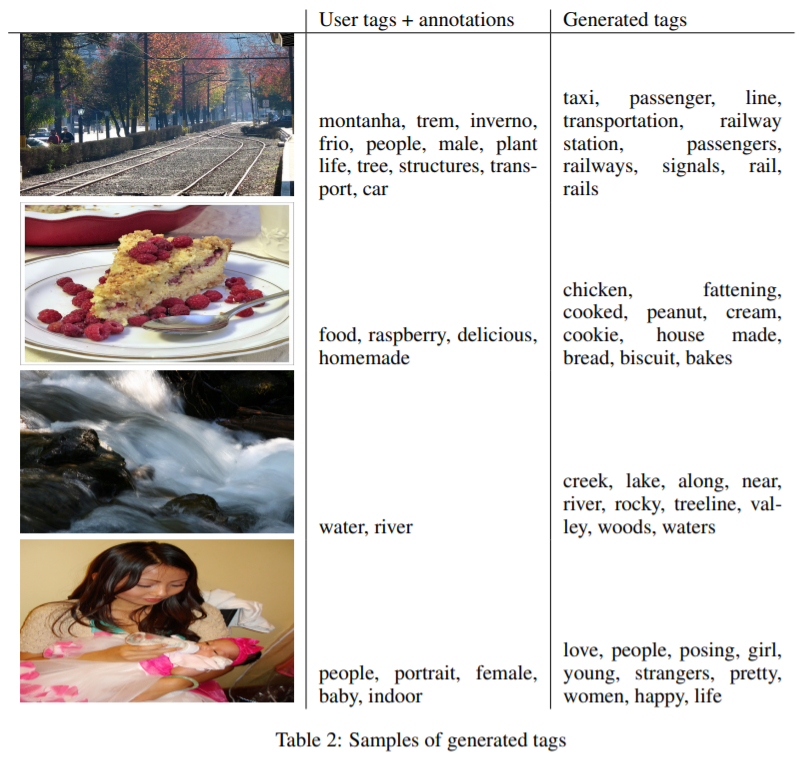

위 테이블 Table 2는 여러 이미지들에 대해 사람이 직접 넣은 tag와 CGAN이 생성해낸 태그를 비교한 것이다. 꽤 좋은 결과를 도출해낸 것을 확인할 수 있다.

## **결론**

논문에서 보여준 결과는 극도로 초기 단계지만, CGAN의 잠재력을 보여줬다. CGAN은 **condition variable y를 추가하여 원하는 조건에 해당하는 결과물**을 얻었다.